In [25]:
import requests
import numpy

from yaml import safe_load
from matplotlib import pyplot
from sklearn.manifold import TSNE
from elasticsearch import Elasticsearch

## Configuration

In [26]:
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gray', 'orange', 'brown', 'darkorange', 'aqua', 'pink', 'violet', 'magenta', 'indigo']
colors = ['lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'b', 'g', 'r', 'c', 'lightgray', 'lightgray', 'lightgray', 'lightgray']
queries_weather = ['weather', 'weather forecast', 'weather forecast service', 'the api returns the next 4 days of weather forecasts']
queries_sports = ['american sports', 'american sports news', 'american sports news articles', 'An API for accessing news articles across various sports leagues including NFL']
queries_books = ['digital', 'digital book', 'digital book library', 'API for managing digital library resources retrieving books authors and publishers']
queries_restaurant = ['restaurant', 'restaurant booking', 'restaurant booking platform', 'Allows users to create a booking for a specific restaurant ID of the restaurant']

In [27]:
# Retrieve configuration file for elastic
with open("../debug.config.yml") as config:
    config_file = safe_load(config)

In [28]:
es = Elasticsearch(
    f"{config_file['elastic']['protocol']}://{config_file['elastic']['host']}:{config_file['elastic']['port']}",
    basic_auth= (config_file['elastic']['user'], config_file['elastic']['password']),
)

In [29]:
es.info()

ObjectApiResponse({'name': 'es', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'Lx5-0idaRLeK62lK4UJUog', 'version': {'number': '8.12.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '48a287ab9497e852de30327444b0809e55d46466', 'build_date': '2024-02-19T10:04:32.774273190Z', 'build_snapshot': False, 'lucene_version': '9.9.2', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [30]:
def perform_search_query(query: str) -> list[list[int]]:
    embeddings = []
    
    url: str = f"http://localhost:{config_file['backend']['port']}/api/v1/search?k=10"
    body: dict[str, str|list[str]] = {
        "fields": ["metadata"]
    }
    
    if query: body["fragment"] = query
    response = requests.post(url, json=body).json()
    ids = [doc['metadata']['mongo-id'] for doc in response]
    
    for idx in ids:
        response = es.search(index="apis", body={
            "query": {
                "nested": {
                    "path": "metadata",
                        "query": {
                            "term": {
                              "metadata.mongo-id": idx
                            }
                        }
                    }
                }
        })["hits"]["hits"][0]["_source"]
        
        embeddings.append(response["embedding"])
    
    response = requests.post("http://127.0.0.1:8501/v1/models/universal-encoder:predict", json={"instances": [query]}).json()
    embeddings.append(response["predictions"][0])
    
    return embeddings

In [31]:
def compute_tsne(vectors_array: list[list[int]], queries_list: list[str]):
    pyplot.figure(figsize=(13, 8))
    
    data = TSNE(perplexity=40, n_iter=3000, random_state=2).fit_transform(numpy.array(vectors_array))
    
    for i in range(0, len(data), 11):
        alpha = 1 if colors[int(i / 11)] == "lightgray" else 0.5
        
        pyplot.scatter(data[i + 10, 0], data[i + 10, 1], marker='1', color=colors[int(i / 11)], label=queries_list[int(i / 11)][:10]+"...", alpha=alpha)
        pyplot.scatter(data[i:i + 10, 0], data[i:i + 10, 1], marker='o', color=colors[int(i / 11)], alpha=alpha)
        
    pyplot.ylim((-1500, 1500))
    pyplot.xlim((-1500, 1500))
    pyplot.legend()
    pyplot.savefig("out.pdf")

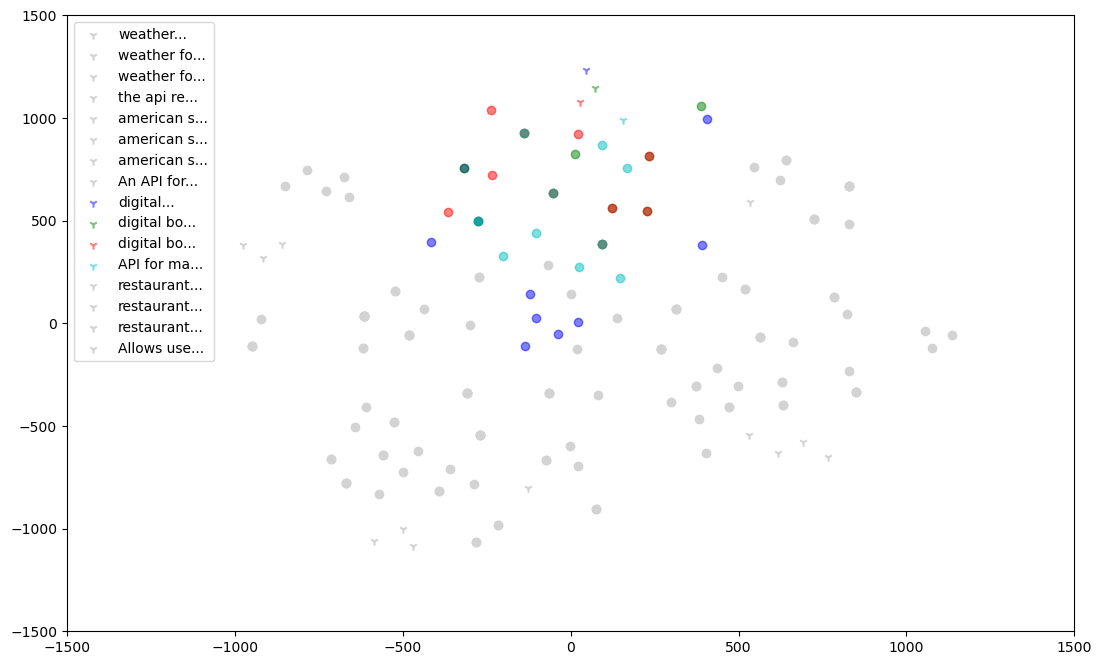

In [32]:
queries = []
vectors = []

queries.extend(queries_weather + queries_sports + queries_books + queries_restaurant)
vectors.extend([vec for query in queries_weather for vec in perform_search_query(query)])
vectors.extend([vec for query in queries_sports for vec in perform_search_query(query)])
vectors.extend([vec for query in queries_books for vec in perform_search_query(query)])
vectors.extend([vec for query in queries_restaurant for vec in perform_search_query(query)])

compute_tsne(vectors, queries)